# Wrapper for Advanced Reactor Cost Reduction Tool

### Problem Objective and Overview
    1. Model, evaluate, regulate the progression of plant's capital cost and build-time from FOAK to NOAK
    2. Only capital costs considered as those are main component involved in intial investment into nuclear plant.

### Qualitative Description of the Levers, Variables, Accounts, and Baseline Cost
- **Levers**
    - main or core inputs $u$ from the stakeholders such as utilities, reactor vendors, policy-makers, government,
    - to subjectively define externalities such as contractor proficiency, government support, etc.
    - following **Levers** are leveraged to generate different cost-reduction scenarios, 
      1. **N**: number of firm orders for a given reactor concept
      2. **FP**: to include cost of first plant in the computation of running average cost from FOAK to NOAK (only for graphical representation)
      3. **IR**: interest rate in percentage terms at which the captial is borrowed, can be used to accommodate subsidized interest rate
      4. **ITC**: federal tax credit that can be leveraged post completion of the project, 
      5. **n_ITC**: number of plants **ITC** is applied to,
      6. **DesCompl_PreConst**: design completed, in percentage terms, before the construction of the plant begins (internalizes licensing amendments, rework etc that might be needed if the design is significantly incomplete), usually one of the main reasons for delays and cost overruns 
      7. **Comp_Matur**: design novelty/maturity of the components, possibly impacting the supply chain delays/efficiencies, **Comp_Matur** $\in \{0,1,2\}$ where $0$ corresponds to a new component, $1$ corresponds to a mature component in non-nuclear industry and may entail increased licensings, and $2$ is the most mature component with use in nuclear industry 
      8. **eff_SuppCh**, **n_SuppCh**: supply chain efficiecny quantified based on contractor's past experience and performance, **eff_SuppCh** $\in [0,2]$, where the numerical value increases with the proficiency;  **n_SuppCh** is the minimal number of plants to achieve the most proficient supply chain, specifically, **eff_SuppCh**$=2$ 
      9. **eff_AE**, **n_AE**: proficiency of the architect/engineering contractor, again **eff_AE** $\in [0,2]$, where the numerical value increases with the proficiency;  **n_AE** is the minimal number of plants to achieve the highest proficiency
      10. **eff_Constr**, **n_Constr**: proficiency of the construction firm modeled similarly, **eff_Constr** $\in [0,2]$, and **n_Constr** denoting the minimal number of plants to achieve maximum proficiency
      11. **CrossSite_Stand**: modeling in percentage terms the design of the plant standardized across multiple sites reactors are to be built across
      12. **Modular_Constr**: TRUE/FALSE input by the user to the question whether modular construction is deployed
      13. **Comm_BOP**: TRUE/FALSE input by the user to the question whether balance of plant (BOP) can be commercially sourced from non-nuclear vendors (TRUE) or if nuclear qualifications are required (FALSE)
      14. **NonSafety_RB**: again TRUE/FALSE input by the user if the reactor building is non-safety related (TRUE) or not (FALSE)
- **Variables**
    - state variables $x$ with upper and lower limits, or intermediate/endogenous parameters which are not user-defined, 
    - cannot be controlled explicitly but are calculated using the user inputs or **Levers**,
    - crucial for insights into project performance for the direct impacts on the accounts with the following **Variables**
      1. **amt_rwrk**: accommodates work redone to address design changes, quality control and inspection failures, expressed as percentage of the total plant that needs rework
      2. **delay_SuppCh**: supply chain delays expressed in months
      3. **lbr_productivity**: labor productivity measured in percentage terms
      4. **blk_ord_red**: expected reduction in component cost with a firm order book, i.e., with value of **N** under **Levers** being greater than unity
      5. **eff_exp**: efficient use of labor and material, resulting in cost reductions
- **Accounts**:
    - cost parameters to build cost function over a timeline $y$, leverages cost of items in the code of accounts (COA),
    - assumption: costs modeled same from FOAK to NOAK
    - only capital costs are considered from higher-level COAs, including mainly direct, indirect and financing cost accounts, following quantifications are also performed: 
      1. **OCC**: overnight capital cost, COA $10$ thorugh $50$ considered, without financial costs
      2. **TCI**: total capital investment, COA $10$ thorugh $60$ considered, including financial costs
      3. **net_OCC**: **OCC** adjusted with returns from **ITC** (under **Levers**), models the impact of **ITC** on overnight capital cost
      4. **net_TCI**: **TCI** adjusted with returns from **ITC** (under **Levers**), can be modeled as sum of **net_OCC** and financial costs

### 
- **Baseline Cost**:
    - modeled as **WE_FOAK** or well-executed FOAK,
    - constructed to be independent of **Levers** so as to not model any cost reductions or cost overruns,
    - does not include modeling of poor project execution or supply chain delays - **Levers** that may result in cost overruns are dialed up, namely **DesCompl_PreConst**, **Comp_Matur**, **eff_SuppCh**, **eff_AE**, **eff_Constr**
    - does not include cost reduction with bulk orders for components, or experience gathered with multiple deployments - **Levers** that may result in cost reductions are dialed down, namely **N**, **Modular_Constr**, **NonSafety_RB**
    - **WE_FOAK** acted upon by **Levers** to regulate cost evolution until NOAK,
    - regulated via linear relationships between **Levers**, **Variables**, and **Accounts**
  

### Importing Libraries

In [1]:
import pandas as pd;          import numpy as np;        import matplotlib as mpl;        import matplotlib.pyplot as plt;
import seaborn as sns;        import math;               import scipy.stats as stats;     

### Uploading Data from Excel Sheet

##### Generic Functions

In [2]:
def sheet_info(path_sheet, subsheet_names_dict):
    #
    # Reading Excel sheets as Dataframes
    #
    subsheet_keys   = subsheet_names_dict.keys()
    subsheet_names  = subsheet_names_dict.values()
    #
    subsheets_df_dict = {};
    #
    for subsheet_keys, subsheet_names in subsheet_names_dict.items():
        subsheets_df_dict[subsheet_keys] = pd.read_excel(path_sheet, sheet_name=subsheet_names_dict[subsheet_names])
    return subsheets_df_dict

##### Excel Info Declaration

In [3]:
# Declaring Excel File Path
path_data_file = '/Users/popln/Library/CloudStorage/OneDrive-IdahoNationalLaboratory/SAI/CostReduction/JupNotebooks/Info.xlsx'

# Declaring Subsheets within Excel File
subsheet_names_dict = {}
subsheet_names_dict['n_Samples'] = 'n_Samples';  subsheet_names_dict['Levers'] = 'Levers'; 


##### Data Extraction

In [4]:
# Extracting Declared Sheets as a Dictionary
df_dict = sheet_info(path_data_file, subsheet_names_dict)

### Sampling

##### Generic Functions

In [5]:
# Arguments within the function

# n_Samples_df, all_var_df ::  'n_Samples_df' contains number of scenarios to be sampled and simulated, 
#                              'all_var_df' provided from the Excel sheet contains name, distribution types for  
#                               multiple inputs to be sampled/varied

def sampler(n_Samples_df, all_var_df): #  min_, max_, mean, stds
  #  
  # Reading number of samples requested
  #    
  n_Samples     = n_Samples_df.iloc[0, 0]
  #  
  # Intitialize number of levers and sample-storing array
  #
  n_var          = all_var_df.shape[0]   # all_var_df.shape[0] provides of number of variables to be randomized
  random_samples = np.empty((n_var, n_Samples))    # random sample-storing array
  #  
  # Extract information regarding distributions
  #
  dist_type = all_var_df['Distribution'];    min_ = all_var_df['Min'];     max_   = all_var_df['Max'];     med_ = all_var_df['Median']
  low_ = all_var_df['Low'];                 high_ = all_var_df['High'];    Set_   = all_var_df['Set'];     Probabilities_ = all_var_df['Probabilities']
  Type = all_var_df['Type'];
  #  
  # Intitialize random sample-storing array
  #
  for iter in range(n_var):
    # print(iter)
    #  
    # Normal Distribution Sampler: Discrete and Continuous
    #
    if dist_type[iter] in ['normal', 'Normal', 'Gaussian', 'gaussian']:
      random_samples[iter, :]  = trunc_normal(min_[iter], low_[iter], med_[iter], high_[iter], max_[iter], n_Samples)
      if Type[iter] in ['discrete', 'Discrete', 'Integer', 'integer']:
          random_samples[iter, :] = np.round(random_samples[iter, :])
    #  
    # Lognormal Distribution Sampler: Discrete and Continuous
    #
    elif dist_type[iter] in ['lognormal', 'LogNormal', 'Lognormal']:
      random_samples[iter, :] = truncate_shift_lognormal(min_[iter], low_[iter], med_[iter],  high_[iter], max_[iter], n_Samples)
      if Type[iter] in ['discrete', 'Discrete', 'Integer', 'integer']:
          random_samples[iter, :] = np.round(random_samples[iter, :])
    #  
    # Triangular Distribution Sampler: Discrete and Continuous
    #
    elif dist_type[iter] in ['triangular', 'Triangular']:
      random_samples[iter, :] = np.random.triangular(left=min_[iter], mode=med_[iter], right=max_[iter], size=n_Samples)
      if Type[iter] in ['discrete', 'Discrete', 'Integer', 'integer']:
          random_samples[iter, :] = np.round(random_samples[iter, :])
    #  
    # Uniform Distribution Sampler: Discrete and Continuous
    #
    elif dist_type[iter] in ['uniform', 'Uniform']:
      random_samples[iter, :] = np.random.uniform(left=min_[iter], right=max_[iter], size=n_Samples)
      if Type[iter] in ['discrete', 'Discrete', 'Integer', 'integer']:
          random_samples[iter, :] = np.round(random_samples[iter, :])
    #  
    # Binary/Boolean/Discrete-Set Distribution Sampler
    #
    elif dist_type[iter] in ['binary', 'Binary', 'Boolean', 'boolean', 'set', 'Set']:
      random_samples[iter, :] = np.random.choice(eval('['+Set_[iter]+']'), size = n_Samples, p = eval('['+Probabilities_[iter]+']'))
    else:
      raise ValueError("Enter valid distribution type. Invalid entry: {}".format(dist_type[i]))

  return random_samples


# Truncated Normal
def trunc_normal(min_, low_, med_, high_, max_, n_Samples):
    #
    # 'low_' and 'high_' assumed to provide a spread of 4 standard deviations
    #
    std_dev = (high_ - low_)/4
    #
    # 'mean' same as 'median' provided in excel sheet due to distribution's symmetry 
    #
    mean_   = med_ 
    #
    # Scaling and shifting due to underlying script of scipy's truncated normal
    #
    a, b = (min_ - mean_)/std_dev, (max_ - mean_)/std_dev
    #
    # Generating 'n_Samples' samples from truncated normal
    #
    sample_ = stats.truncnorm.rvs(a=a, b=b, loc=mean_, scale=std_dev, size=n_Samples)
    return sample_


# Truncated and Shifted Lognormal via Normal Representation
def truncate_shift_lognormal(min_, low_, med_, high_, max_, n_Samples):
    # Calculate the shape and scale parameters
    #
    # X is lognormal, so the distribution logX is gaussian/normal in nature, 
    # Thus, values of log(X_low) and log(X_high) assumed to span four standard deviations of the normal distribution of logX, 
    # thereby providing shape factor for the lognormal distribution of X.
    #
    std_dev = (np.log(high_)-np.log(low_))/4   # standard deviation of normal distribution logX between high and low value
    #
    # 'median_' in the excel sheet provides the scale or the median for the distribution of logX
    #
    mean_ = np.log(med_)                             # mean of logX
    #
    # Scaling and shifting due to underlying script of scipy's truncated normal
    #
    a, b = (np.log(min_) - mean_)/std_dev, (np.log(max_) - mean_)/std_dev
    #
    # Generating ''n_Samples' samples from truncated normal
    #
    sample_normal = stats.truncnorm.rvs(a=a, b=b, loc=mean_, scale=std_dev, size=n_Samples)
    sample_       = np.exp(sample_normal)
    return sample_



##### Generating Samples

In [6]:
Lever_samples = sampler(df_dict['n_Samples'], df_dict['Levers'])

### Histogram Plots

##### Non-Generic Code :: Specific to Lever Distribution Plots Only

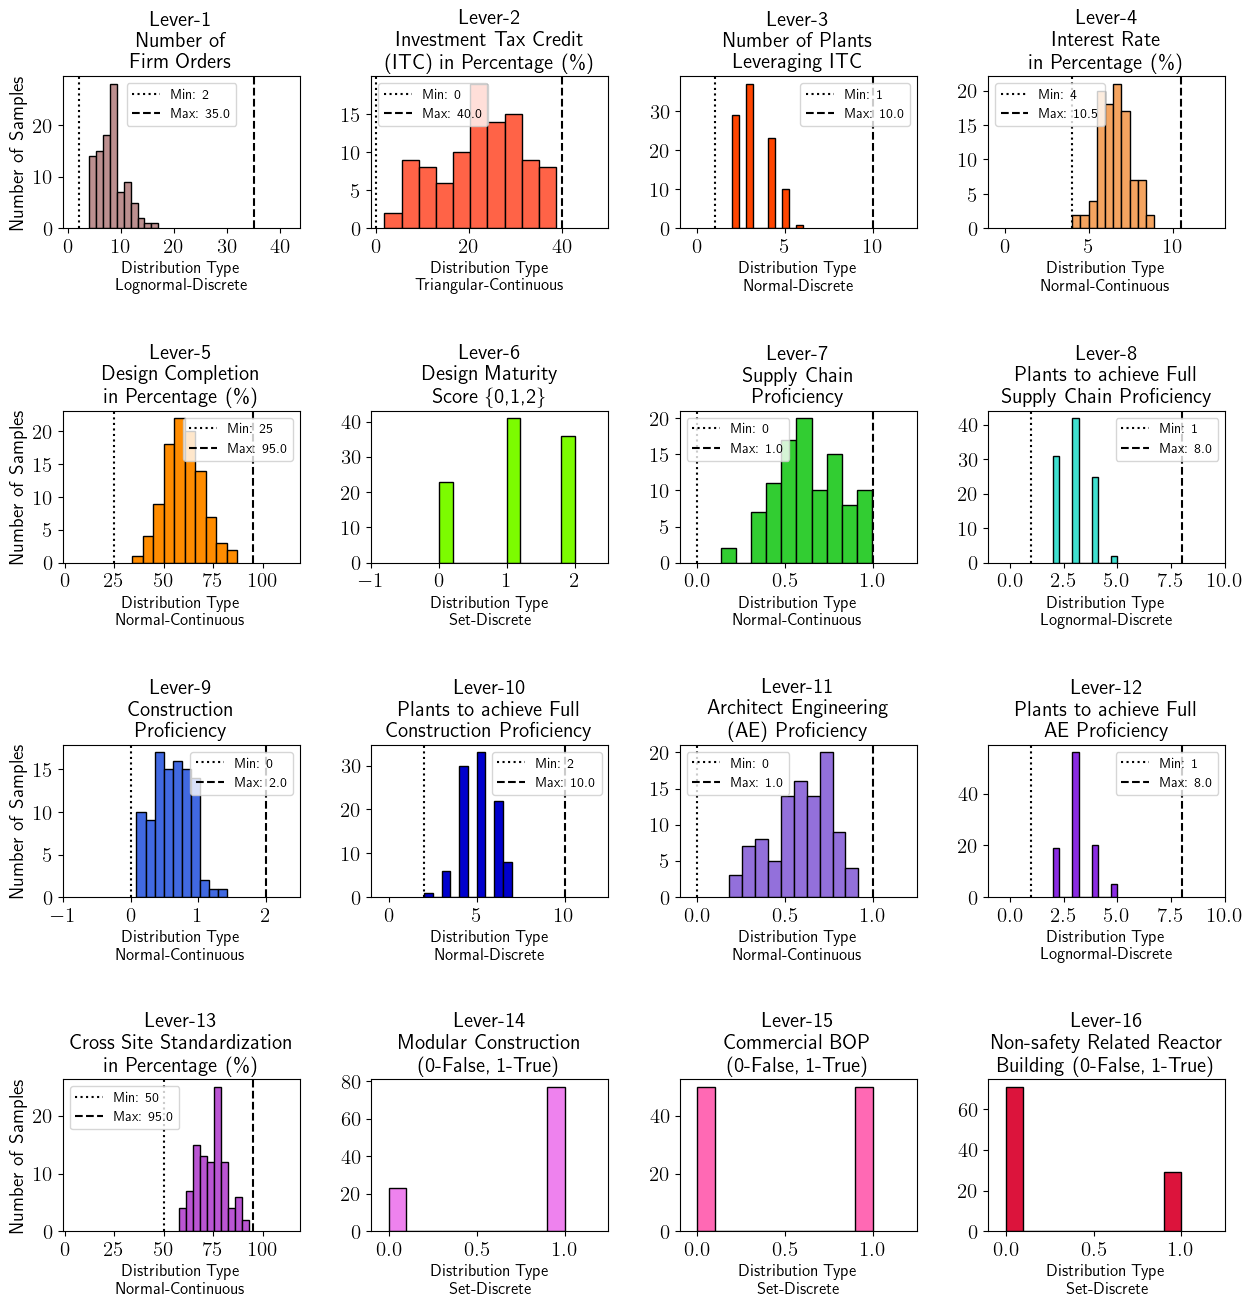

In [10]:
# Figure Specifications
fig, axs = plt.subplots(4, 4);         # Declaring subplots
sq_size = 15;                          # Declaring size
fig.set_size_inches(sq_size,sq_size)   # Setting Size
fig.subplots_adjust(wspace=0.3, hspace = 1.2) # Spacing out plots
plt.rc('text', usetex=True)

# Lever names and colors
lever_title =['Number of \n Firm Orders', 'Investment Tax Credit \n (ITC) in Percentage (\%)', 'Number of Plants \n Leveraging ITC',
            'Interest Rate \n in Percentage (\%)', 'Design Completion \n in Percentage (\%)', 'Design  Maturity \n Score \{0,1,2\}', 
             'Supply Chain \n Proficiency', 'Plants to achieve Full \n Supply Chain Proficiency', 
             'Construction \n Proficiency', 'Plants to achieve Full \n Construction Proficiency',
             'Architect Engineering \n (AE) Proficiency', 'Plants to achieve Full \n AE Proficiency',
             'Cross Site Standardization \n in Percentage (\%)', 'Modular Construction \n (0-False, 1-True)', 'Commercial BOP \n (0-False, 1-True)',
             'Non-safety Related Reactor \n  Building (0-False, 1-True)']

colors_ = ['rosybrown','tomato','orangered','sandybrown','darkorange',
           'lawngreen','limegreen','turquoise','royalblue','mediumblue','mediumpurple','blueviolet','mediumorchid',
           'violet','hotpink', 'crimson']


# Plotting histograms
for y in range(0,16):   
    axs=plt.subplot(4, 4, y+1)
    x_min = -1
    if df_dict['Levers']['Min'][y] == 0 and df_dict['Levers']['Max'][y] == 1:
        x_min = -0.1
    axs.set_xlim(x_min,1.25*df_dict['Levers']['Max'][y]); 
    plt.hist(Lever_samples[y,:], color = colors_[y], edgecolor='black')
    plt.title('Lever-{}'.format(y+1)+'\n'+lever_title[y], fontsize=15)
    if y % 4 == 0:
        plt.ylabel('Number of Samples', fontsize =14)
    plt.xticks(fontsize =15); plt.yticks(fontsize =15)
    plt.xlabel('Distribution Type' + '\n' + df_dict['Levers']['Distribution'][y]+'-'+df_dict['Levers']['Type'][y],fontsize=12)
    #
    if  str(df_dict['Levers']['Set'][y]).lower() == 'nan':
        min_ = df_dict['Levers']['Min'][y];  max_ = df_dict['Levers']['Max'][y]
        axs.axvline(x=min_, color='black', linestyle=':', label=f'Min: {min_}')
        axs.axvline(x=max_, color='black', linestyle='--', label=f'Max: {max_}')
        axs.legend(fontsize=10)



## Wrapper Function

In [11]:
# Main code to be called here for 'n_Samples'

for y in range(0,df_dict['n_Samples'].iloc[0, 0]):
    # 
    # Iterating value of Levers over 'n_Samples' and Declaring each Lever Separately for Main Code
    #
    N = Lever_samples[0,y];                      ITC = Lever_samples[1,y];           
    n_ITC = Lever_samples[2,y];                  IR = Lever_samples[3,y]; 
    DesCompl_PreConst = Lever_samples[4,y];      Comp_Matur = Lever_samples[5,y];
    eff_SuppCh = Lever_samples[6,y];             n_SuppCh = Lever_samples[7,y];
    eff_AE = Lever_samples[8,y];                 n_AE = Lever_samples[9,y]; 
    eff_Constr = Lever_samples[10,y];            n_Constr = Lever_samples[11,y];
    CrossSite_Stand = Lever_samples[12,y];       Modular_Constr = Lever_samples[13,y];
    Comm_BOP = Lever_samples[14,y];              NonSafety_RB   = Lever_samples[15,y];
    # 
    # Executing Scripts for Cost Reduction Evaluation
    #
    print('Main code will be called here and the lever samples will be re-decalred for each iteration.')
    
    

Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each iteration.
Main code will be called here and the lever samples will be re-decalred for each